In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from keras import optimizers
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras_preprocessing.image import load_img
from keras import applications
from keras.models import model_from_json

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os


In [85]:
IMAGE_FOLDER_PATH="train/"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [86]:
dataset.head(10)

image_path target
0      train/cat.0.jpg    cat
1      train/cat.1.jpg    cat
2     train/cat.10.jpg    cat
3    train/cat.100.jpg    cat
4   train/cat.1000.jpg    cat
5  train/cat.10000.jpg    cat
6  train/cat.10001.jpg    cat
7  train/cat.10002.jpg    cat
8  train/cat.10003.jpg    cat
9  train/cat.10004.jpg    cat

In [87]:
dataset.tail(10)

image_path target
24990  train/dog.9990.jpg    dog
24991  train/dog.9991.jpg    dog
24992  train/dog.9992.jpg    dog
24993  train/dog.9993.jpg    dog
24994  train/dog.9994.jpg    dog
24995  train/dog.9995.jpg    dog
24996  train/dog.9996.jpg    dog
24997  train/dog.9997.jpg    dog
24998  train/dog.9998.jpg    dog
24999  train/dog.9999.jpg    dog

In [88]:
target_counts=dataset['target'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


In [89]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target!=show and show!="both":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(WIDTH,HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

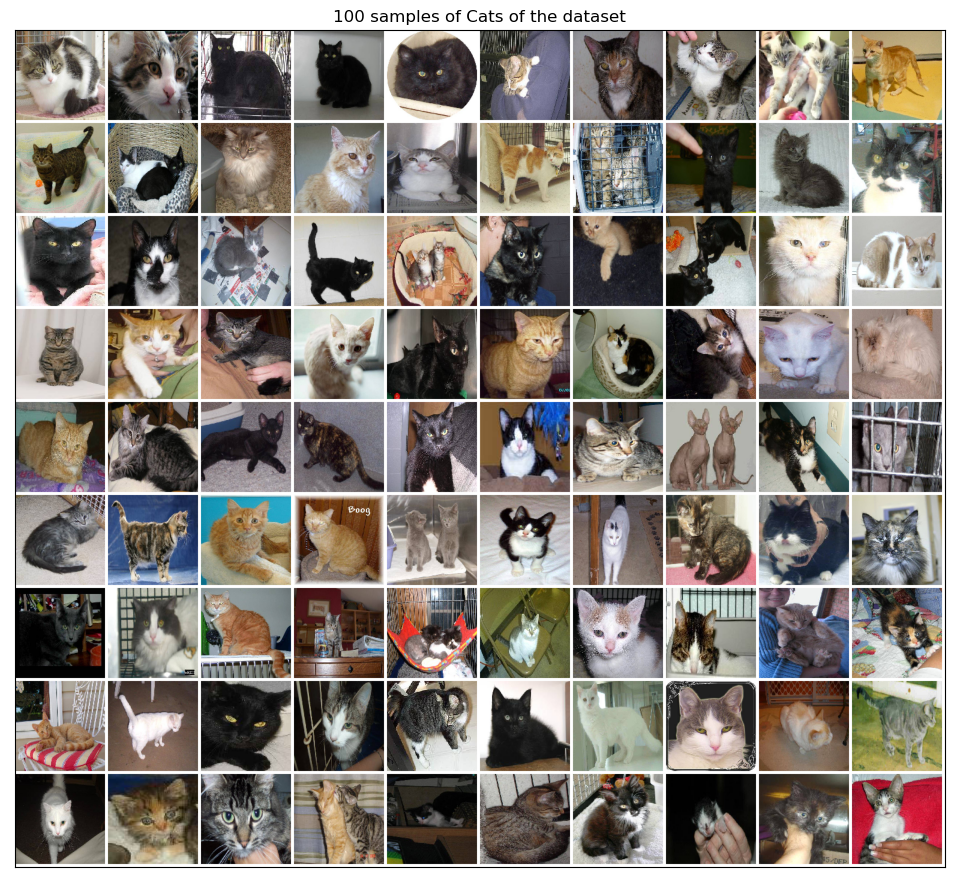

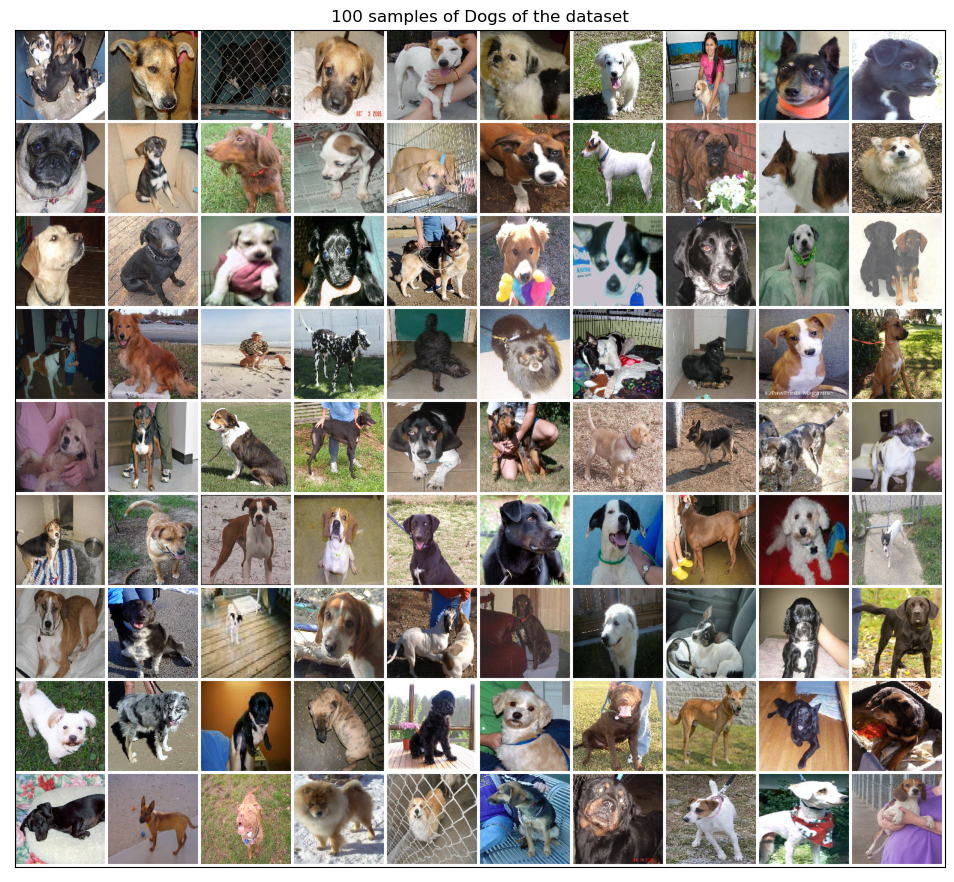

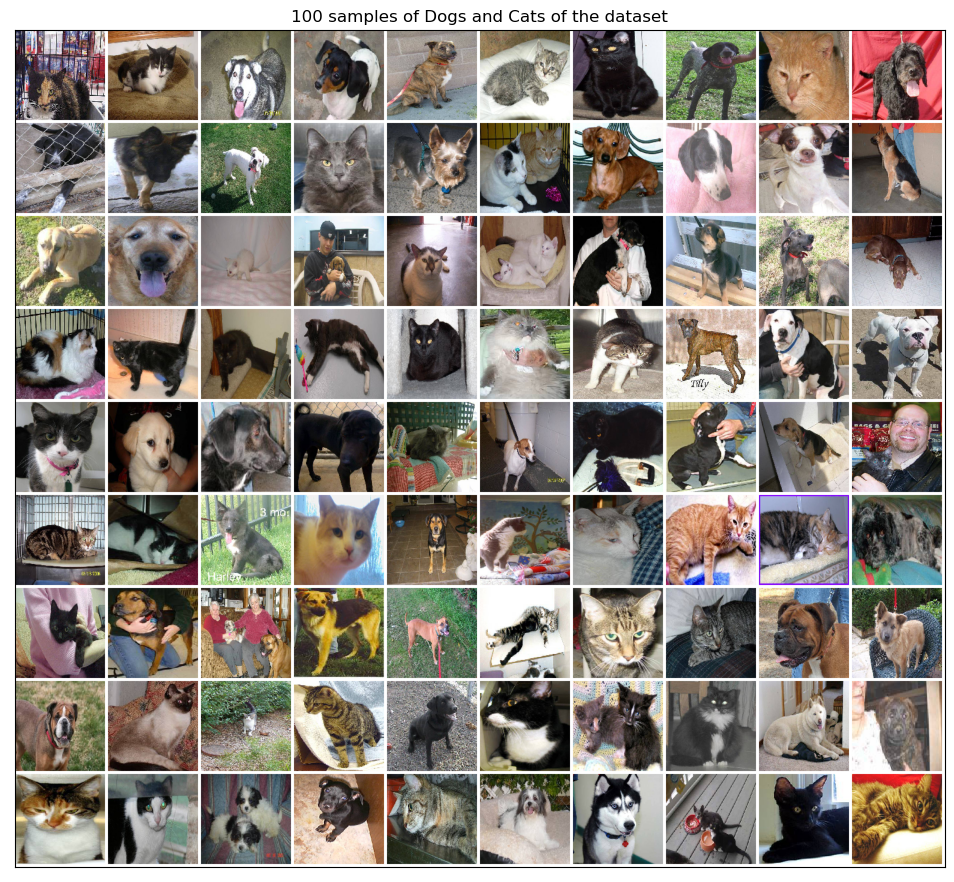

In [90]:
show_gallery(show="cat")
show_gallery(show="dog")
show_gallery(show="both")

In [91]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validation Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convolutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

In [92]:
model=models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 batch_normalization_8 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 73, 73, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 71, 71, 64)       

In [93]:
model.compile(loss="binary_crossentropy", 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=["accuracy"])
print("[INFO]: model compiled...")

[INFO]: model compiled...


C:\Users\acer\.conda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [94]:
dataset_train, dataset_test=train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)

In [95]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [96]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [97]:
modelHistory=model.fit_generator(train_datagenerator,
                                epochs=10,
                                validation_data=test_datagenerator,
                                validation_steps=dataset_test.shape[0]//150,
                                steps_per_epoch=dataset_train.shape[0]//150
                                )

C:\Users\acer\AppData\Local\Temp\ipykernel_19812\2120418605.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelHistory=model.fit_generator(train_datagenerator,


Epoch 1/10
133/133 [==============================] - 558s 4s/step - loss: 0.9188 - accuracy: 0.5595 - val_loss: 0.6951 - val_accuracy: 0.5024
Epoch 2/10
133/133 [==============================] - 527s 4s/step - loss: 0.6739 - accuracy: 0.6183 - val_loss: 0.9835 - val_accuracy: 0.5030
Epoch 3/10
133/133 [==============================] - 526s 4s/step - loss: 0.6261 - accuracy: 0.6564 - val_loss: 1.8931 - val_accuracy: 0.5032
Epoch 4/10
133/133 [==============================] - 525s 4s/step - loss: 0.5867 - accuracy: 0.6912 - val_loss: 1.5846 - val_accuracy: 0.5226
Epoch 5/10
133/133 [==============================] - 526s 4s/step - loss: 0.5654 - accuracy: 0.7096 - val_loss: 1.5823 - val_accuracy: 0.5475
Epoch 6/10
133/133 [==============================] - 524s 4s/step - loss: 0.5436 - accuracy: 0.7237 - val_loss: 1.5244 - val_accuracy: 0.5679
Epoch 7/10
133/133 [==============================] - 523s 4s/step - loss: 0.5259 - accuracy: 0.7391 - val_loss: 0.9393 - val_accuracy: 0.6416

Train Accuracy:0.775
Test Accuracy:0.629


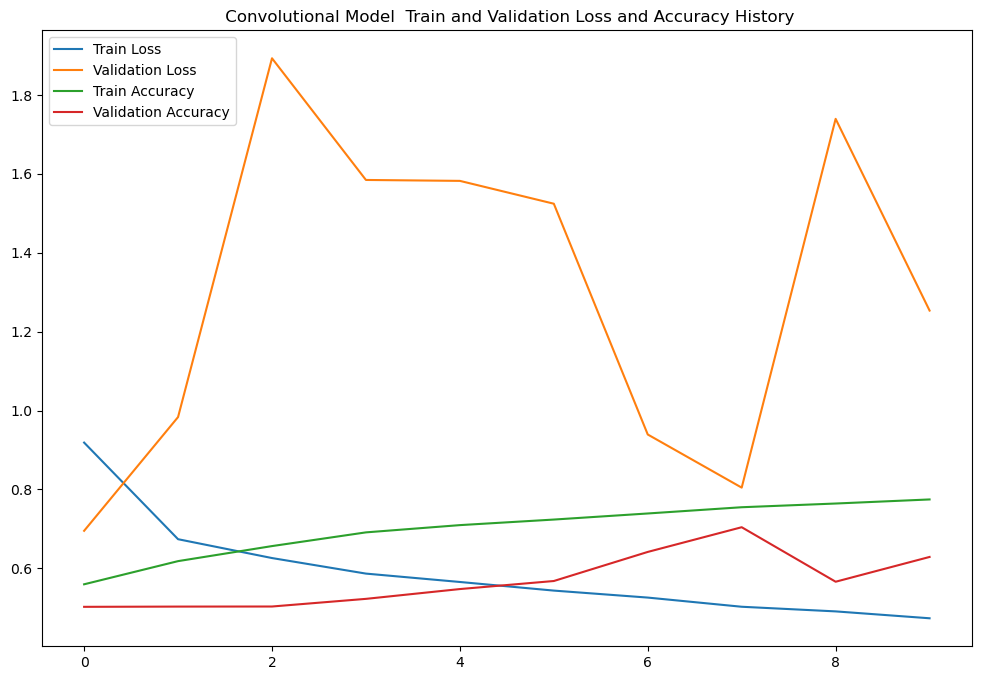

In [98]:
print("Train Accuracy:{:.3f}".format(modelHistory.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(modelHistory.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory, model_name="")

In [99]:
model=applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(WIDTH, HEIGHT, 3))
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                        

 conv2_block4_1_conv (Conv2D)   (None, 38, 38, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 38, 38, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 38, 38, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 38, 38, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 19, 19, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 19, 19, 32)   36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 19, 19, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 19, 19, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 19, 19, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 19, 19, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 19, 19, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 19, 19, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 19, 19, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 9, 9, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 9, 9, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 9, 9, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 9, 9, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 9, 9, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 9, 9, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 9, 9, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 9, 9, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 9, 9, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 9, 9, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 9, 9, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 9, 9, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 9, 9, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 9, 9, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 9, 9, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 9, 9, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 9, 9, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block29_0_relu (Activati  (None, 9, 9, 1152)  0           ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 9, 9, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block33_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 9, 9, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 9, 9, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 9, 9, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 9, 9, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 9, 9, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 9, 9, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block42_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 9, 9, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 9, 9, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization) 

 conv5_block11_1_conv (Conv2D)  (None, 4, 4, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block24_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
          

                                                                                                  
 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [100]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [101]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [102]:
#After loaded the model,need to compile model one more time

loaded_model.compile(loss="binary_crossentropy", 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=["accuracy"])
print("[INFO]: model compiled...")

[INFO]: model compiled...


C:\Users\acer\.conda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [103]:
counter=0
features=list()
for path, target in zip(full_paths, targets):
    img=load_img(path, target_size=(WIDTH, HEIGHT))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    feature=loaded_model.predict(img)
    features.append(feature)
    counter+=1
    if counter%2500==0:
        print("[INFO]:{} images loaded".format(counter))

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step
[INFO]:2500 images loaded
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 63ms/step
[INFO]:5000 images loaded
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step
[INFO]:7500 images loaded
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 61ms/step
[INFO]:10000 images loaded
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 67ms/step
[INFO]:12500 images loaded
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 73ms/step
[INFO]:15000 images loaded
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 72ms/step
[INFO]:17500 images loaded
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 101ms/step
[INFO]:20000 images loaded
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 73ms/step
[INFO]:22500 images loaded
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 76ms/step
[INFO]:25000 images loaded


In [104]:
features=np.array(features)
print("Before reshape,features.shape:",features.shape)
features=features.reshape(features.shape[0], 4*4*1920)
print("After reshape, features.shape:",features.shape)

Before reshape,features.shape: (25000, 1, 4, 4, 1920)
After reshape, features.shape: (25000, 30720)


In [105]:
le=LabelEncoder()
targets=le.fit_transform(targets)

In [106]:
print("features.shape:",features.shape)
print("targets.shape:",targets.shape)

features.shape: (25000, 30720)
targets.shape: (25000,)


In [107]:
X_train, X_test, y_train, y_test=train_test_split(features, targets, test_size=0.2, random_state=42)

In [108]:
from sklearn.model_selection import cross_val_score

In [109]:
clf=LogisticRegression(solver="lbfgs")
print("{} training...".format(clf.__class__.__name__))
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The model trained and used to predict the test data...")

LogisticRegression training...


C:\Users\acer\.conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model trained and used to predict the test data...


In [110]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Classification Report:\n",metrics.classification_report(y_test, y_pred, target_names=["cat", "dog"]))

Accuracy: 0.8248
Confusion Matrix:
 [[2031  443]
 [ 433 2093]]
Classification Report:
               precision    recall  f1-score   support

         cat       0.82      0.82      0.82      2474
         dog       0.83      0.83      0.83      2526

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

